<a href="https://colab.research.google.com/github/ubiratanfilho/tcc-embraer/blob/dev/src/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using CNNs for Sea Victims Detection

## Dependencies

In [3]:
import zipfile
import torch
from torch import nn
from torchvision import transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.metrics import accuracy_score

## Downloading data

In [2]:
!gdown 1qnvxy2EiLzEKWx6Du8U2qkTJF15lWtvy

Downloading...
From: https://drive.google.com/uc?id=1qnvxy2EiLzEKWx6Du8U2qkTJF15lWtvy
To: /content/separated.zip
100% 7.31G/7.31G [01:58<00:00, 61.7MB/s]


## Unziping files

In [4]:
!ls '.'

sample_data  separated.zip


In [6]:
with zipfile.ZipFile('separated.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

## Reading Data

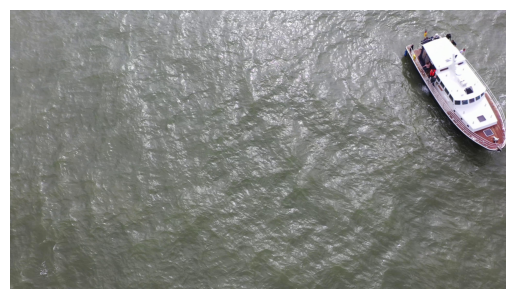

Class:  0


In [7]:
# Acessing the GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Reading data
# images dir
train_dir = './separated/train'
val_dir = './separated/val'

# define transforms: resize the image to 3840 x 2160
transform = transforms.Compose(
    [transforms.Resize((2160, 3840)),
     transforms.ToTensor()]
)
# load data
train_data = datasets.ImageFolder(train_dir, transform=transform)
val_data = datasets.ImageFolder(val_dir, transform=transform)

# define dataloaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=64, shuffle=True)

image, label = trainloader.dataset[110]
# show the image
plt.imshow(image.permute(1, 2, 0))
plt.axis('off')
plt.show()
print("Class: ", train_data.classes[label])

In [8]:
image.size()

torch.Size([3, 2160, 3840])

## Training and Evaluation

In [9]:
model = nn.Sequential(
    nn.Conv2d(3, 16, kernel_size=3, padding=1),
    nn.BatchNorm2d(16),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(16, 64, kernel_size=3, padding=1),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),

    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.BatchNorm2d(128),
    nn.ReLU(),
    nn.MaxPool2d(2),

    # classifier
    nn.Flatten(),
    nn.Linear(270*480, 1024),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(1024, 256),
    nn.ReLU(),
    nn.Dropout(0.2),

    nn.Linear(256, 2),
    nn.Sigmoid()
)

model.to(device)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=129600, out_features=1024, bias=True)
  (14): ReLU()
  (15): Dropout(p=0.2, inplace=False)
  (16): Linear(in_features=1024, out_features=256, bias=Tr

In [11]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [12]:
def train(model, loader, epoch):
    model.train()

    start = time.time()

    epoch_loss = []
    pred_list = []
    label_list = []

    for image, label in loader:
        image = image.to(device)
        label = label.to(device)

        ypred = model(image)
        loss = criterion(ypred, label)
        epoch_loss.append(loss.item())

        _, pred = torch.max(ypred, 1)
        pred_list.append(pred.cpu().numpy())
        label_list.append(label.cpu().numpy())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = np.mean(epoch_loss)
    pred_list = np.concatenate(pred_list)
    label_list = np.concatenate(label_list)

    acc = accuracy_score(pred_list, label_list)

    end = time.time()
    print('#### Training ####')
    print('Epoch: %d, loss: %.3f, acc: %.3f, time: %.3f' % (epoch, epoch_loss, acc, end-start))

    return epoch_loss

In [13]:
def evaluate(test_loader, model, epoch):
    model.eval()

    start = time.time()

    epoch_loss = []
    pred_list = []
    label_list = []
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(device)
            label = label.to(device)

            ypred = model(image)
            loss = criterion(ypred, label)
            epoch_loss.append(loss.item())

            _, pred = torch.max(ypred, 1)
            pred_list.append(pred.cpu().numpy())
            label_list.append(label.cpu().numpy())

    epoch_loss = np.mean(epoch_loss)
    pred_list = np.concatenate(pred_list)
    label_list = np.concatenate(label_list)

    acc = accuracy_score(pred_list, label_list)
    end = time.time()

    print('#### Testing ####')
    print('Epoch: %d, loss: %.3f, acc: %.3f, time: %.3f' % (epoch, epoch_loss, acc, end-start))

In [ ]:
train_loss = []
test_loss = []
epochs = 10
for epoch in range(epochs):
    train_loss.append(train(model, trainloader, epoch))
    evaluate(valloader, model, epoch)